### Contrastive Explanations on a public dataset
Quick test on the Boston housing dataset as it can be seen as a cold-start problem.

Updates 22.04.2021 - Show contrastive explanations

In [1]:
from sklearn.datasets import load_boston
import matplotlib
import category_encoders as ce
import pandas as pd
import numpy as np
from os import path as _p

from contrastiveRegressor import contrastiveRegressor

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

import seaborn as sns
import matplotlib.pyplot as plt
import preprocessing_utils as pt
import fcn_helpers as fhelp
import datetime as dt


Bad key savefig.frameon in file /usr/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /usr/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /usr/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlibrc file from
https

In [2]:
# prepare some data
boston = load_boston()
y = boston.target
X = pd.DataFrame(boston.data, columns=boston.feature_names)
inputVars = X.columns.tolist()

In [3]:
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
# Regressor
num_iterations = 600
learning_rate  = 0.15
depth = 12
num_neighbours = 5
validation_test_size = 0.20
feat_importance_keyword = 'feature_importances_'

In [5]:
# Create the forecaster
contrastiveReg = contrastiveRegressor(num_neighbours = num_neighbours, 
validation_test_size = validation_test_size)

# CatBoost
cb_model = CatBoostRegressor(iterations=num_iterations, learning_rate=learning_rate,
depth=depth, loss_function='RMSE', cat_features=None, silent=False)
# Set the regressor
contrastiveReg.set_regressor(cb_model, feat_importance_keyword, inputVars)
# fit the regressor
contrastiveReg.fit(X_train.values, y_train)
# eval results
contrastiveReg.predict_eval_test()
eval_results = contrastiveReg.get_results()

Preparing Training set...
Training set (1515, 26). Evaluation (380, 26)...done.
...Symmetrical Weights
MAE: 1.21
MSE: 2.23
RMSE: 1.49
meanError: -0.34
MAPE: 6.45
R2: 0.97
frc_error: 0.05
frc_bias: -0.01
frc_acc: 1.01
Var explained: 0.97


In [6]:
# Predict
contrastiveReg.predict(X_test.values)
cold_start_results = contrastiveReg.get_results()

...Symmetrical Weights


In [7]:
idx_review = 16
contrastiveReg.get_contrastive_explanation(idx_review, X_test, y_test)

,LSTAT,RM,DIS,PTRATIO,NOX,B,RAD,AGE,TAX,CRIM,...,ZN,CHAS,y_train,delta_y_train,y_train_plus_delta,y_train_distances,y_train_weights,y_actual,y_forecast,y_weighted_forecast
var_importance,36.393825,22.306304,6.629455,4.923878,4.911928,4.850029,4.363484,4.298297,3.952308,3.124069,...,1.362846,0.556963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbour_0,17.930000,5.961000,2.086900,19.100000,0.581000,378.090000,2.000000,92.900000,188.000000,0.092990,...,0.000000,0.000000,20.5,-0.282172,20.217828,0.114641,8.722859,NaN,NaN,NaN
neighbour_1,14.810000,5.986000,1.992900,19.100000,0.581000,385.020000,2.000000,88.400000,188.000000,0.169020,...,0.000000,0.000000,21.4,-1.739481,19.660519,0.497952,2.008224,NaN,NaN,NaN
neighbour_2,14.270000,6.004000,2.197400,19.100000,0.581000,377.670000,2.000000,84.100000,188.000000,0.071650,...,0.000000,0.000000,20.3,-2.037732,18.262268,0.617170,1.620299,NaN,NaN,NaN
neighbour_3,14.370000,5.870000,2.257700,19.100000,0.581000,389.150000,2.000000,69.700000,188.000000,0.068990,...,0.000000,0.000000,22.0,-2.722540,19.277460,0.776252,1.288242,NaN,NaN,NaN
neighbour_4,16.900000,5.942000,1.966900,21.200000,0.624000,378.250000,4.000000,93.500000,437.000000,0.322640,...,0.000000,0.000000,17.4,2.281550,19.681550,1.114944,0.896906,NaN,NaN,NaN
124,17.580000,5.879000,2.006300,19.100000,0.581000,379.380000,2.000000,95.800000,188.000000,0.098490,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,18.8,19.419925,19.806436


In [12]:
#import utils.file_utils as fu
#fu.to_random_excel_file(contrastiveReg.get_contrastive_explanation(idx_review, X_test, y_test), writeIndex=True)

In [13]:
# Sort by importance
df_feature_importances = cold_start_results.get('df_feat_importances', None)
print(df_feature_importances)

                 0
LSTAT    36.393825
RM       22.306304
DIS       6.629455
PTRATIO   4.923878
NOX       4.911928
B         4.850029
RAD       4.363484
AGE       4.298297
TAX       3.952308
CRIM      3.124069
INDUS     2.326615
ZN        1.362846
CHAS      0.556963


In [14]:
_=contrastiveReg.get_frc_errors(y_test, cold_start_results['y_hat_weighted'])

MAE: 2.41
MSE: 14.60
RMSE: 3.82
meanError: 0.20
MAPE: 12.70
R2: 0.79
frc_error: 0.11
frc_bias: 0.01
frc_acc: 0.99
Var explained: 0.79


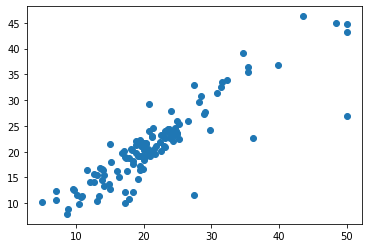

In [15]:
plt.scatter(y_test, cold_start_results['y_hat_weighted'])

In [16]:
# Predict with CatBoost (original)
y_hat_catboost = fhelp.frc_plain_CatBoost(num_neighbours, validation_test_size,
    num_iterations, learning_rate, depth, \
    contrastiveReg.X_train, contrastiveReg.y_train, X_test)


0:	learn: 8.7221063	test: 8.6497482	best: 8.6497482 (0)	total: 57ms	remaining: 34.1s
50:	learn: 1.1212170	test: 4.5186128	best: 4.5186128 (50)	total: 2.7s	remaining: 29s
100:	learn: 0.3828253	test: 4.4409489	best: 4.4401521 (99)	total: 5.37s	remaining: 26.5s
150:	learn: 0.1441431	test: 4.4347493	best: 4.4341525 (137)	total: 8.32s	remaining: 24.7s
200:	learn: 0.0582845	test: 4.4347032	best: 4.4341525 (137)	total: 11.1s	remaining: 22s
250:	learn: 0.0277647	test: 4.4349122	best: 4.4341525 (137)	total: 13.7s	remaining: 19s
300:	learn: 0.0136617	test: 4.4348717	best: 4.4341525 (137)	total: 16.5s	remaining: 16.4s
350:	learn: 0.0070845	test: 4.4350787	best: 4.4341525 (137)	total: 19s	remaining: 13.5s
400:	learn: 0.0040204	test: 4.4352004	best: 4.4341525 (137)	total: 21.6s	remaining: 10.7s
450:	learn: 0.0020967	test: 4.4351743	best: 4.4341525 (137)	total: 24.1s	remaining: 7.97s
500:	learn: 0.0010494	test: 4.4351369	best: 4.4341525 (137)	total: 26.8s	remaining: 5.29s
550:	learn: 0.0005311	test

In [ ]:
# Predict with Extra Random Trees (sklearn)
y_hat_ERT = fhelp.frc_plain_extratrees(num_neighbours, depth, validation_test_size, 
                                            contrastiveReg.X_train, contrastiveReg.y_train, X_test.values)

In [ ]:
# Predict with NGBoost
y_hat_NGBoost = fhelp.frc_plain_ngboost(num_iterations, learning_rate, validation_test_size, 
                                        contrastiveReg.X_train, contrastiveReg.y_train, 
                                        X_test.values)

In [ ]:
# Arrange the results in a DF so we can easily plot them
df_test = X_test.copy()
df_test['y_actual'] = y_test
df_test['y_hat_catboost'] = y_hat_catboost
df_test['y_hat_extratrees'] = y_hat_ERT
df_test['y_hat_ngboost'] = y_hat_NGBoost
df_test['y_hat_contrastive'] = cold_start_results['y_hat_weighted']

#### Arrange the results per model

In [ ]:
df_frc_metrics = []
for model_type in ['contrastive','catboost', 'extratrees', 'ngboost']:
    df_frc_metrics.append(pd.DataFrame([contrastiveReg.get_frc_errors(y_test, df_test['y_hat_' + model_type], False)], index=[model_type]))

df_frc_metrics = pd.concat(df_frc_metrics)
df_frc_metrics